In [55]:
import pickle
import sympy
import pandas as pd
import sys
sys.path.append('../../')
import cartpole_error_monitoring

def load_from_file(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
        F = data['F']
        lmd_time_series = data['lmd_time_series']
        state_time_series = data['state_time_series']
    return F, lmd_time_series, state_time_series

F, lmd_time_series, state_time_series = load_from_file('symbolic_F.pkl')


In [56]:
for i in range(F.shape[1]):
    variables = set()
    matrix = F[i,0]
    variables.update(matrix.free_symbols)
    print(list(variables))

for i in range(state_time_series.shape[0]):
    for j in range(state_time_series.shape[1]):
        variables = set()
        matrix = state_time_series[i,j]
        variables.update(matrix.free_symbols)
        print(list(variables))

for i in range(lmd_time_series.shape[0]):
    for j in range(lmd_time_series.shape[1]):
        variables = set()
        matrix = lmd_time_series[i,j]
        variables.update(matrix.free_symbols)
        print(list(variables))


[u0_1, x_ref[0], q[3], x0, m_c, m_p, g, q_terminal[2], q[2], x3, x1, x_ref[3], q[1], q_terminal[1], u0_0, x_ref[2], x_ref[1], u0_2, q_terminal[3], q_terminal[0], r[0], q[0], l, x2]
[x0]
[x0, x2]
[x0, u0_0, m_c, m_p, g, x1, l, x2]
[x1]
[x3, x1]
[m_c, m_p, g, x3, u0_0, x1, l]
[x2]
[m_c, m_p, g, u0_0, x1, l, x2]
[u0_1, u0_0, m_c, m_p, g, x3, x1, l, x2]
[x3]
[m_c, m_p, g, x3, u0_0, x1, l]
[u0_1, u0_0, m_c, m_p, g, x3, x1, l]
[x_ref[0], x0, u0_0, m_c, m_p, g, q[0], q_terminal[0], x1, l, x2]
[x_ref[0], x0, u0_0, m_c, m_p, g, q[0], q_terminal[0], x1, l, x2]
[x_ref[0], x0, u0_0, m_c, m_p, g, q_terminal[0], x1, l, x2]
[u0_1, x_ref[0], q[3], x0, m_c, m_p, g, q_terminal[2], q[2], x3, x1, x_ref[3], q[1], q_terminal[1], u0_0, x_ref[2], x_ref[1], u0_2, q_terminal[3], q_terminal[0], l, x2]
[u0_1, m_c, m_p, g, q_terminal[2], x3, x1, x_ref[3], q[1], q_terminal[1], u0_0, x_ref[2], x_ref[1], u0_2, q_terminal[3], l, x2]
[q_terminal[1], u0_0, m_c, x_ref[1], m_p, g, x3, x1, l]
[u0_1, x_ref[0], x0, m_c, m_p,

In [57]:
# 読み込みたいファイル名のリスト
filenames = ['generated_code_uopt.log', 'generated_code_x.log']

# 各ファイルを読み込み、その結果をリストに保存します
df_list = [pd.read_csv(filename, delim_whitespace=True, header=None) for filename in filenames]

# 各データフレームをnumpyの行列に変換し、それをリストに保存します
u_matrix, x_matrix = [df.values for df in df_list]
x_matrix[k,:]
x_matrix.shape[0]


10000

simulation step: 10000
0
50


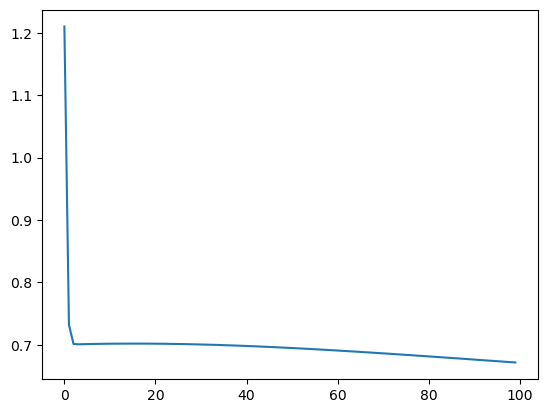

In [58]:
from math import sqrt

from matplotlib import pyplot as plt


config = {
    "nx": 4,  # Number of states
    "nu": 1,  # Number of control inputs
    "ocp_name": "generated_code",  # Name of the optimal control problem
    "Tf": 2.0,  # Time horizon for the optimal control problem
    "alpha": 0.0,  # Soft horizon parameter
    "sampling_time": 0.001,  # Sampling time for the discrete-time optimal control problem
    "N": 3,  # Number of discretized intervals
    "finite_difference_epsilon": 1.0e-08,  # Epsilon for finite difference approximations
    "zeta": 1000,  # Penalty parameter
    "kmax": 5,  # Maximum number of iterations for the semi-smooth Newton method
    "initial_time": 0,  # Initial time for the simulation
    "initial_state": [0, 0, 0, 0],  # Initial state for the simulation
    "simulation_length": 10,  # Length of the simulation in seconds
    "solution_initial_guess": [
        0.01
    ],  # Initial guess for the optimal control problem solution
    "tolerance": 1.0e-06,  # Tolerance for the optimal control problem solution
    "max_iterations": 50,  # Maximum number of iterations for the optimal control problem solution
}

# Create and configure the AutoGenU object
auto_gen_u = cartpole_error_monitoring.create_autogenu_object(config)
cartpole_error_monitoring.set_parameters(auto_gen_u, config)


["m_c", 2], ["m_p", 0.2], ["l", 0.5], ["g", 9.80665]
x = sympy.Matrix(sympy.symbols(f'x0:{config["nx"]}'))  # Initial state as variables
u = sympy.Matrix([sympy.symbols(f'u{i}_{j}') for i in range(config["nu"]) for j in range(config["N"])]).reshape(config["nu"], config["N"])
r = sympy.symbols('r[0:%d]' %(config["nu"]))
q_terminal = sympy.symbols('q_terminal[0:%d]' %(config["nx"]))
q = sympy.symbols('q[0:%d]' %(config["nx"]))
x_ref = sympy.symbols('x_ref[0:%d]' %(config["nx"]))


sub_param = auto_gen_u.make_subs_dicts()

# Create a list to store the L2 norms
l2_norms = []

simulation_steps = int(config["simulation_length"]/config["sampling_time"])
print("simulation step:", simulation_steps)

# for k in range(int(config["simulation_length"]/config["sampling_time"])):
for k in range(100):
    # Create the substitutions for the state and input at the current time step
    subs_x = [(x[l], x_matrix[k,l]) for l in range(config["nx"])]
    subs_u = [(u[l], u_matrix[k,l]) for l in range(config["N"])]

    # Loop over the control inputs
    norm = 0
    for i in range(config["N"]):
        for j in range(config["nu"]):
            # Calculate the squared L2 norm of F
            F_val = F[i,j].subs(sub_param).subs(subs_x).subs(subs_u)
            norm += F_val**2
    
    if k%50 == 0:
        print(k)
    # Append the square root of the norm (i.e., the L2 norm) to the list
    l2_norms.append(sqrt(norm))


# Plot the L2 norm of F
plt.plot(l2_norms)